# Necessary Install and Import

In [1]:
!pip install category_encoders


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, Normalizer
from category_encoders import TargetEncoder
from sklearn.svm import SVC, LinearSVC
from scipy.stats import skew
from sklearn.model_selection import train_test_split
import typing
from IPython.display import display, HTML

In [3]:
# Load data sets
os.environ["HOME"] = "C:/Users/Sam/Documents/Python Scripts";

# Loan data
loan_data_trn_path = os.path.join(os.environ["HOME"], "loan-10k.lrn.csv")
loan_data_tst_path = os.path.join(os.environ["HOME"], "loan-10k.tes.csv")
loan_data_sol_path = os.path.join(os.environ["HOME"], "loan-10k.sol.ex.csv")
loan_data_trn = pd.read_csv(loan_data_trn_path, sep=",")
loan_data_tst = pd.read_csv(loan_data_tst_path, sep=",")
loan_data_sol = pd.read_csv(loan_data_sol_path, sep=",")
loan_data_tst = pd.merge(loan_data_tst, loan_data_sol, on='ID', how='inner')

# Breast cancer data
cancer_data_trn_path = os.path.join(os.environ["HOME"], "breast-cancer-diagnostic.shuf.lrn.csv")
cancer_data_tst_path = os.path.join(os.environ["HOME"], "breast-cancer-diagnostic.shuf.tes.csv")
cancer_data_sol_path = os.path.join(os.environ["HOME"], "breast-cancer-diagnostic.shuf.sol.ex.csv")
cancer_data_trn = pd.read_csv(cancer_data_trn_path, sep=",")
cancer_data_tst = pd.read_csv(cancer_data_tst_path, sep=",")
cancer_data_sol = pd.read_csv(cancer_data_sol_path, sep=",")
cancer_data_tst = pd.merge(cancer_data_tst, cancer_data_sol, on='ID', how='inner')

# Loan default data
default_data_path = os.path.join(os.environ["HOME"], "Loan_default.csv")
default_data = pd.read_csv(default_data_path, sep=",")

# Mushroom data
mushroom_data_path = os.path.join(os.environ["HOME"], "mushrooms.csv")
mushroom_data = pd.read_csv(mushroom_data_path, sep=",")

In [4]:
num_cols = []
cat_cols = []
print(loan_data_trn['grade'].value_counts())

grade
C    2989
B    2881
A    1821
D    1449
E     621
F     182
G      57
Name: count, dtype: int64


# Pre-processing functions

###### Defining functions for data pre-processing

In [5]:
def filterColumnsWithType(x_train:pd.DataFrame)-> typing.Tuple[list[str], list[str]]:
    """ 
    Filters out numeric and categorical columns from a dataframe.
    
    Parameters
    --------
    x_train: Train data frame
    
    Returns
    --------
    num_cols: columns having numerical values
    cat_cols: columns having categorical values
    """
    
    num_cols = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()
    return num_cols, cat_cols

def checkMissingValuesPerColumn(df:pd.DataFrame) -> pd.Series:
    """ 
    Checks if there are any missing values in every column of a dataframe.
    
    Parameters
    --------
    df: input data frame
    
    Returns
    --------
    missing values per column
    """
    
    return df.isnull().sum()

def splitDependentIndependent(df:pd.DataFrame, col:str)->typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Splits a dataframe into dependent features and independent features.
    It separates the target column from the dataframe.
    
    Parameters
    --------
    df: Input data frame
    col: target column name or dependent feature name
    
    Returns
    --------
    x_train: dataframe of independent features
    y_train: dataframe of dependent feature
    """
    
    x_train = df.drop(col, axis=1)
    y_train = df[col]
    return x_train, y_train

def dropHighCorrColumn(df, threshold=0.95, h=12, v=10) -> typing.Tuple[pd.DataFrame, list[str]]:
    """ 
    Drops the highly correlated columns.
    
    Parameters
    --------
    df: input data frame
    threshold: the threshold of determining correlation
    h: horizontal length of plot
    v: vertical length of plot
    
    Returns
    --------
    df: the dataframe without highly correlated columns
    cat_cols: list of dropped highly correlated columns
    """
    
    corr_matrix = df.corr().abs()
    printCorrelationMatrix(corr_matrix, h, v)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    return df.drop(columns=drop_cols), drop_cols

def printCorrelationMatrix(corr_matrix, h=12, v=10):
    """ 
    Prints the correlation matrix.
    
    Parameters
    --------
    corr_matrix: The correlation matrix data
    h: horizontal length of plot
    v: vertical length of plot
    """
    
    plt.figure(figsize=(h, v))
    sns.heatmap(corr_matrix, 
            annot=False,     # Show correlation values
            fmt=".2f",      # 2 decimal places
            cmap="coolwarm",# Color scale
            square=True, 
            cbar_kws={"shrink": 0.75})  # Shrink colorbar
    plt.title("Correlation Matrix (Absolute Values)", fontsize=16)
    plt.tight_layout()
    plt.show()

def categoricalColumnEncoding(x_train:pd.DataFrame, x_test:pd.DataFrame, y_train:pd.DataFrame) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Encodes categorical columns of a dataframe.
    Based on the variations of data in each column the appropriate method is determined.
    If there are upto 5 variations OneHotEncoding is used. For upto 10 variations TargetEncoding is used.
    For more than 10 variations Frequency encoding is used.
    
    Parameters
    --------
    x_train: Train data frame
    x_test: Test data frame
    y_train: Train target data frame
    
    Returns
    --------
    df_train_transformed: Train data frame with encoded categorical columns
    df_test_transformed: Test data frame with encoded categorical columns
    """
    
    df_train_transformed = pd.DataFrame(index=x_train.index)
    df_test_transformed = pd.DataFrame(index=x_test.index)

    for col in cat_cols:
        unique_count = x_train[col].nunique()
        
        if unique_count <= 5:
            # OneHot Encoding
            encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            train_encoded = encoder.fit_transform(x_train[[col]])
            test_encoded = encoder.transform(x_test[[col]])
            new_cols = [f"{col}_{val}" for val in encoder.categories_[0]]
            df_train_transformed[new_cols] = train_encoded
            df_test_transformed[new_cols] = test_encoded
            
        elif 5 < unique_count <= 10:
            # Target Encoding
            encoder = TargetEncoder()
            df_train_transformed[col] = encoder.fit_transform(x_train[[col]], y_train)
            df_test_transformed[col] = encoder.transform(x_test[[col]])
            
        else:
            # Frequency Encoding
            freq_map = x_train[col].value_counts(normalize=True).to_dict()
            df_train_transformed[col] = x_train[col].map(freq_map)
            df_test_transformed[col] = x_test[col].map(freq_map)
            
    return df_train_transformed, df_test_transformed


def plotSkewedNess(df:pd.DataFrame, num_cols_initial:list[str], div_no:int):
    """ 
    Plots the data distribution.
    
    Parameters
    --------
    df: Input data frame
    num_cols_initial: Numerical columns
    div_no: No of individual plots in rows & columns
    """
    
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(num_cols_initial, 1):
        plt.subplot(div_no, div_no, i)
        sns.histplot(df[col], kde=True)
        plt.title(f"{col}\nSkew: {skew(df[col].dropna()):.2f}")
        plt.tight_layout()
    plt.show()


def findOutliers(df:pd.DataFrame):
    """ 
    Filters out the columns having outliers and prints the list of columns.
    
    Parameters
    --------
    df: Input data frame
    """
    
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    params = [1.5, 1.8, 2, 3, 4]

    for i in params:
        print("For: ",i)
        is_outlier = (df < (Q1 - i * IQR)) | (df > (Q3 + i * IQR))
        outlier_columns = is_outlier.any()[is_outlier.any()].index
        outliers = outlier_columns.tolist()
        print(outliers)
        print(len(outliers))

# Model building functions

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

suitable_ml_methods = []

suitable_ml_methods.append(RandomForestClassifier)
suitable_ml_methods.append(KNeighborsClassifier)
suitable_ml_methods.append(LinearSVC)

def trainModel(model_type: type, x_train:pd.DataFrame, y_train:pd.DataFrame, n_est:int=100, n_nb:int=5, C:float=1.0) -> sklearn.base.ClassifierMixin:
    """ 
    Trains appropriate ML algorithm models.
    
    Parameters
    --------
    model_type: The input ML model
    x_train: Train data frame for model train
    y_train: Train target data frame for train
    n_est: n_estimator value for Random Forest classifier model
    n_nb: n_neighbor value for KNN classifier model
    C: Regularization factor for Linear SVC model
    
    Returns
    --------
    trained_model: Trained ML model
    """
    
    trained_model = None
    if model_type.__name__ == 'RandomForestClassifier':
        trained_model = model_type(n_estimators=n_est, random_state=42)
    elif model_type.__name__ == 'KNeighborsClassifier':
        trained_model = model_type(n_neighbors=n_nb)
    elif model_type.__name__ == 'LinearSVC':
        trained_model = model_type(C=C, max_iter=10000)
        
    trained_model.fit(x_train, y_train)
    return trained_model


def predictOnTest(trained_model: sklearn.base.ClassifierMixin, x_test:pd.DataFrame) -> np.ndarray:
    """ 
    Predicts on test data.
    
    Parameters
    --------
    trained_model: Train ML model
    x_test: Test data frame
    
    Returns
    --------
    y_pred: predicted data frame
    """
    y_pred = None
    y_pred = trained_model.predict(x_test)
    return y_pred


def trainAndPredict(x_train_final:pd.DataFrame, 
                    y_train:pd.DataFrame, 
                    x_test_final:pd.DataFrame, 
                    x_train:pd.DataFrame, 
                    x_test:pd.DataFrame)-> dict:
    """ 
    Trains ML Model and predicts on test dataframe.
    
    Parameters
    --------
    x_train_final: Train data frame, used for SVC model
    y_train: Train target data frame, used for SVC model
    x_test_final: Test data frame
    x_train: Train data frame
    x_test: Test data frame
    
    Returns
    --------
    y_preds: dictionary of predicted data frames
    """
    
    y_preds = {}
    
    for model in suitable_ml_methods:
        if model.__name__ == 'LinearSVC':
            trained_model = trainModel(model, x_train_final, y_train)
            y_pred = predictOnTest(trained_model, x_test_final)
        else:
            trained_model = trainModel(model, x_train, y_train)
            y_pred = predictOnTest(trained_model, x_test)
        y_preds[model.__name__] = y_pred
        
    return y_preds


def trainAndPredictWithTuning(x_train_final:pd.DataFrame, 
                              y_train:pd.DataFrame, 
                              x_test_final:pd.DataFrame, 
                              x_train:pd.DataFrame, 
                              x_test:pd.DataFrame)-> dict:
    """ 
    Trains ML Model and predicts on test dataframe. Here the model will be tuned using numerous hyperparameters.
    
    Parameters
    --------
    x_train_final: Train data frame, used for SVC model
    y_train: Train target data frame, used for SVC model
    x_test_final: Test data frame
    x_train: Train data frame
    x_test: Test data frame
    
    Returns
    --------
    y_preds: dictionary of predicted data frames
    """
    
    y_preds = {}
    estimators = [25, 50, 100, 150]
    neighbors = [2, 5, 7, 10]
    c_vals = [0.01, 0.1, 1, 10]
    
    for model in suitable_ml_methods:
        if model.__name__ == 'LinearSVC':
            for i in c_vals:
                trained_model = trainModel(model, x_train_final, y_train, C=i)
                y_pred = predictOnTest(trained_model, x_test_final)
                key = f"{model.__name__} C={i}"
                y_preds[key] = y_pred
                
        elif model.__name__ == 'RandomForestClassifier':
            for i in estimators:
                trained_model = trainModel(model, x_train_final, y_train, n_est=i)
                y_pred = predictOnTest(trained_model, x_test_final)
                key = f"{model.__name__} n_estimator={i}"
                y_preds[key] = y_pred
                
        elif model.__name__ == 'KNeighborsClassifier':
            for i in neighbors:
                trained_model = trainModel(model, x_train_final, y_train, n_nb=i)
                y_pred = predictOnTest(trained_model, x_test_final)
                key = f"{model.__name__} n_neighbors={i}"
                y_preds[key] = y_pred
       
    return y_preds

# Evaluation functions

In [7]:
from sklearn.metrics import f1_score, precision_score, accuracy_score
suitable_metrics = []

# Precision
suitable_metrics.append(precision_score)
# F1
suitable_metrics.append(f1_score)
# accuracy
suitable_metrics.append(accuracy_score)

def compareMetrics(y_true:pd.DataFrame, y_pred:pd.DataFrame) -> dict:
    """ 
    Evaluates scores for various model metrics.
    
    Parameters
    --------
    y_true: True values of target data frame of test data set
    y_pred: Data frame of predicted values
    
    Returns
    --------
    scored: dictionary of various scores
    """
    
    scores = {} # dict of metric name -> metric value/score
    result = {}
    metricsList = ['f1_score', 'precision_score']
    for m in suitable_metrics:
        if m.__name__ in metricsList:
            result = m(y_true, y_pred, average='weighted')
        else:
            result = m(y_true, y_pred)
        scores[m.__name__]= result
    return scores


def evaluate(name:str, y_test:pd.DataFrame, y_pred:pd.DataFrame)->dict:
    """ 
    Evaluates various scores of ML model
    
    Parameters
    --------
    name: Name of ML Model
    y_test: Test data frame
    y_pred: Data frame of predicted values
    
    Returns
    --------
    results: dictionary of various evaluation scores
    """
    
    results = {}
    res = compareMetrics(y_test, y_pred)
    results[name] = res
    return results


def printScores(y_preds:dict):
    """ 
    Prints all scores
    
    Parameters
    --------
    y_preds: Dictionary of predicted data frames
    """
    results = []
    for y in y_preds.keys():
        result = evaluate(y, y_test, y_preds.get(y))
        results.append(result)
        
    flat_results = []
    for model_dict in results:
        for model_name, scores in model_dict.items():
            scores['Model'] = model_name
            flat_results.append(scores)

    df = pd.DataFrame(flat_results)[['Model', 'precision_score', 'f1_score', 'accuracy_score']]
    col_highlight = df.columns[1:]
    styled_table = df.style.set_caption("ML Model Evaluation Metrics") \
    .format(precision=3) \
    .highlight_max(subset=col_highlight, axis=0, color='lightgreen')

    display(HTML(styled_table.to_html()))

## 1. Loan Dataset

### 1.1. Missing values

In [8]:
# Check for missing values
missing_values = checkMissingValuesPerColumn(loan_data_trn)
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)

Series([], dtype: int64)


### 1.2. Drop irrelevant columns

In [9]:
#Drop irrelevant columns
columns_to_drop = ['ID', 'issue_d_month', 'issue_d_year', 'earliest_cr_line_month', 
                  'earliest_cr_line_year', 'last_pymnt_d_month', 'last_pymnt_d_year',
                  'last_credit_pull_d_month', 'last_credit_pull_d_year', 'policy_code']
loan_data_trn = loan_data_trn.drop(columns=columns_to_drop, errors='ignore')
loan_data_tst = loan_data_tst.drop(columns=columns_to_drop, errors='ignore')

### 1.3. Column transformation

In [10]:
# Filters out initial numerical and categorical columns
num_cols_initial, cat_cols_initial = filterColumnsWithType(loan_data_trn)

In [11]:
# Convert term to numerical (extract months)
loan_data_trn['term'] = loan_data_trn['term'].str.extract(r'(\d+)').astype(int)
loan_data_tst['term'] = loan_data_tst['term'].str.extract(r'(\d+)').astype(int)

In [12]:
# Convert emp_length to numerical (simplified)
def convert_emp_length(length):
    if pd.isna(length):
        return 0
    if '10+' in length:
        return 10
    if '< 1' in length:
        return 0
    return int(length.split()[0])

loan_data_trn['emp_length'] = loan_data_trn['emp_length'].apply(convert_emp_length)
loan_data_tst['emp_length'] = loan_data_tst['emp_length'].apply(convert_emp_length)

In [13]:
# Convert binary categorical columns to 0/1
binary_cols = ['pymnt_plan', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag', 'application_type']
for col in binary_cols:
    if col in loan_data_trn.columns:
        loan_data_trn[col] = loan_data_trn[col].map({'n': 0, 'y': 1, 'N': 0, 'Y': 1, 'Cash': 0, 'DirectPay': 1, 'Individual': 0, 'Joint App': 1})
        loan_data_tst[col] = loan_data_tst[col].map({'n': 0, 'y': 1, 'N': 0, 'Y': 1, 'Cash': 0, 'DirectPay': 1, 'Individual': 0, 'Joint App': 1})

In [14]:
# Split both train and test data set in dependent and independent data frame
x_train, y_train = splitDependentIndependent(loan_data_trn, 'grade')
x_test, y_test = splitDependentIndependent(loan_data_tst, 'grade')

In [15]:
# Filters out numerical and categorical columns
num_cols, cat_cols = filterColumnsWithType(x_train)

In [16]:
# Split train and test data set into numerical and categorical columns
x_train_num = x_train[num_cols].copy()
x_test_num = x_test[num_cols].copy()

x_train_cat = x_train[cat_cols].copy()
x_test_cat = x_test[cat_cols].copy()

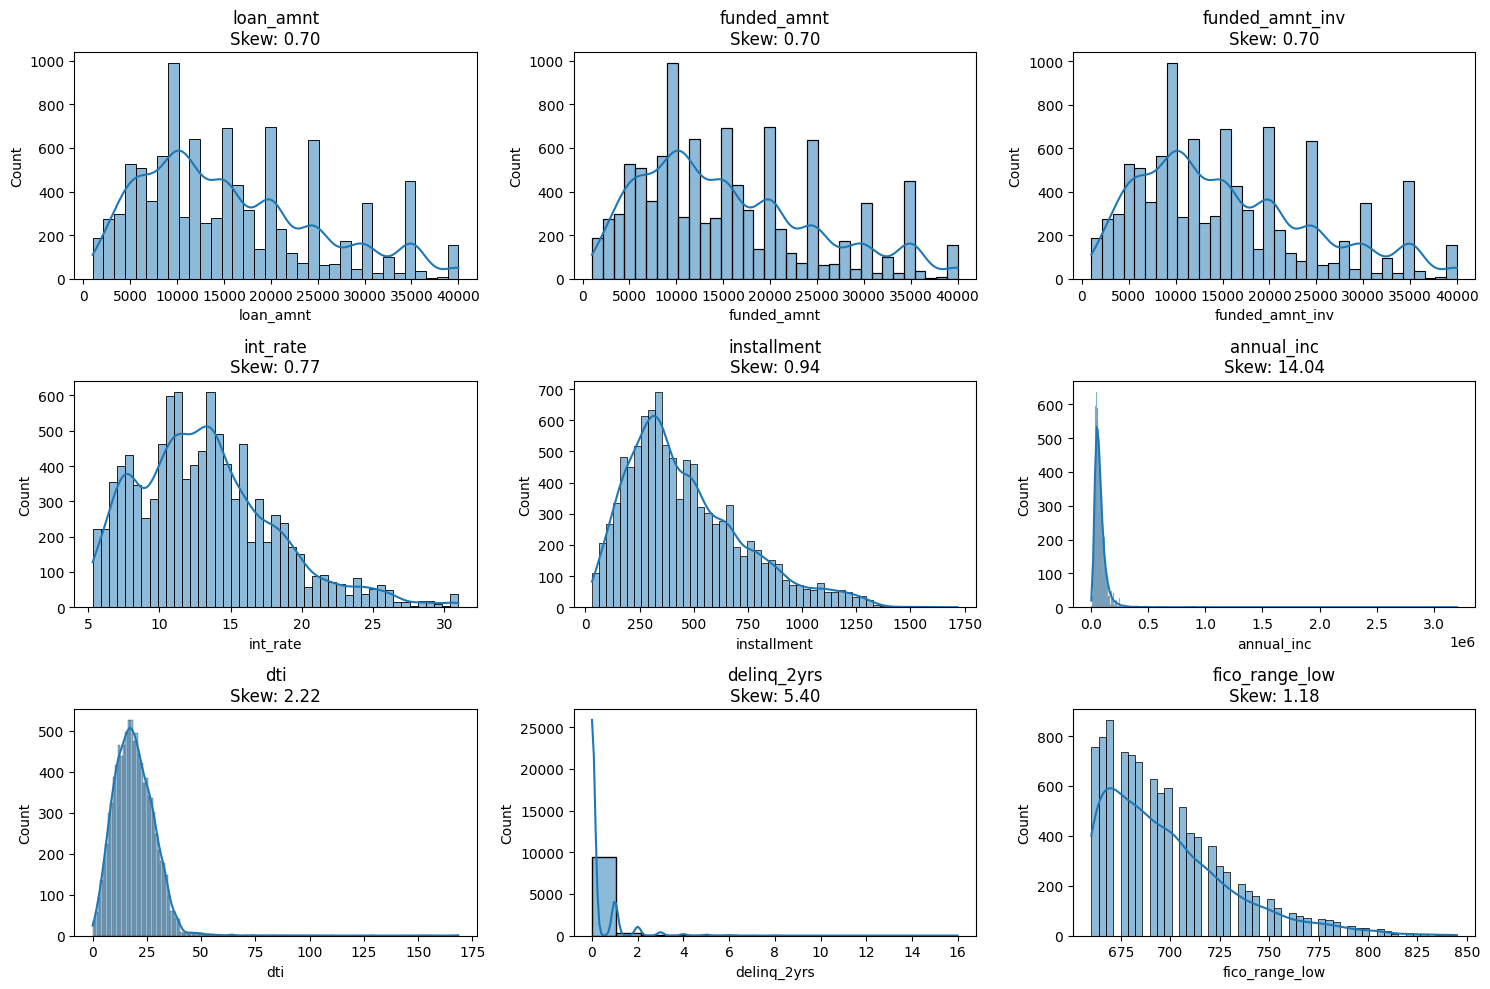

In [17]:
# Plot some skewed columns
subset = num_cols_initial[0:9]
plotSkewedNess(x_train_num, subset, 3)

In [18]:
# Transform categorical columns
x_train_col_trnsfrmd, x_test_col_trnsfrmd = categoricalColumnEncoding(x_train, x_test, y_train)

In [19]:
# Label encode rest of the categorical columns of test and train data set
label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test)

In [20]:
# Find columns having outliers
findOutliers(x_train_num)

For:  1.5
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'pymnt_plan', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'n

In [21]:
# Handle skewed numerical features
skewed_feats = x_train_num.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 0.75].index.tolist()

x_train_num[skewed_cols] = np.log1p(x_train_num[skewed_cols])
x_test_num[skewed_cols] = np.log1p(x_test_num[skewed_cols])

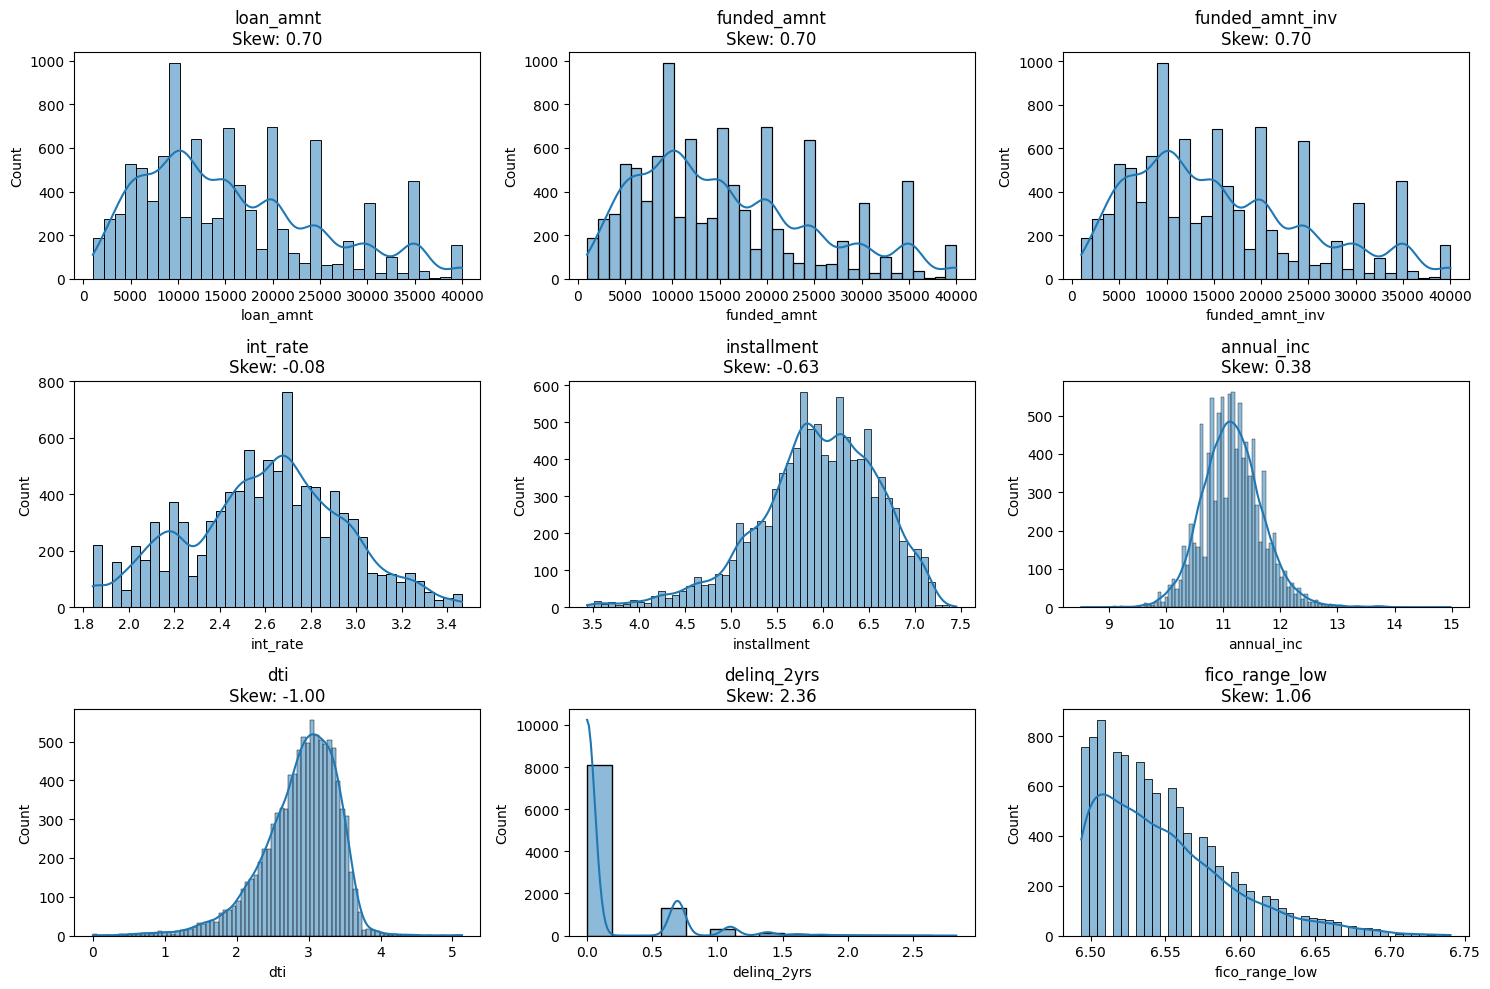

In [22]:
# Plot skewedness after column transformation
plotSkewedNess(x_train_num, subset, 3)

In [23]:
# Find outlierse after optimization and transformation
findOutliers(x_train_num)

For:  1.5
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'pymnt_plan', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_

In [24]:
# Merge transformed numerical and categorical data for both train and test data set
x_train_final_svc = pd.concat([x_train_num.reset_index(drop=True), x_train_col_trnsfrmd.reset_index(drop=True)], axis=1)
x_test_final_svc = pd.concat([x_test_num.reset_index(drop=True), x_test_col_trnsfrmd.reset_index(drop=True)], axis=1)

x_train_final = pd.concat([x_train[num_cols], x_train_col_trnsfrmd.reset_index(drop=True)], axis=1)
x_test_final = pd.concat([x_train[num_cols], x_test_col_trnsfrmd.reset_index(drop=True)], axis=1)

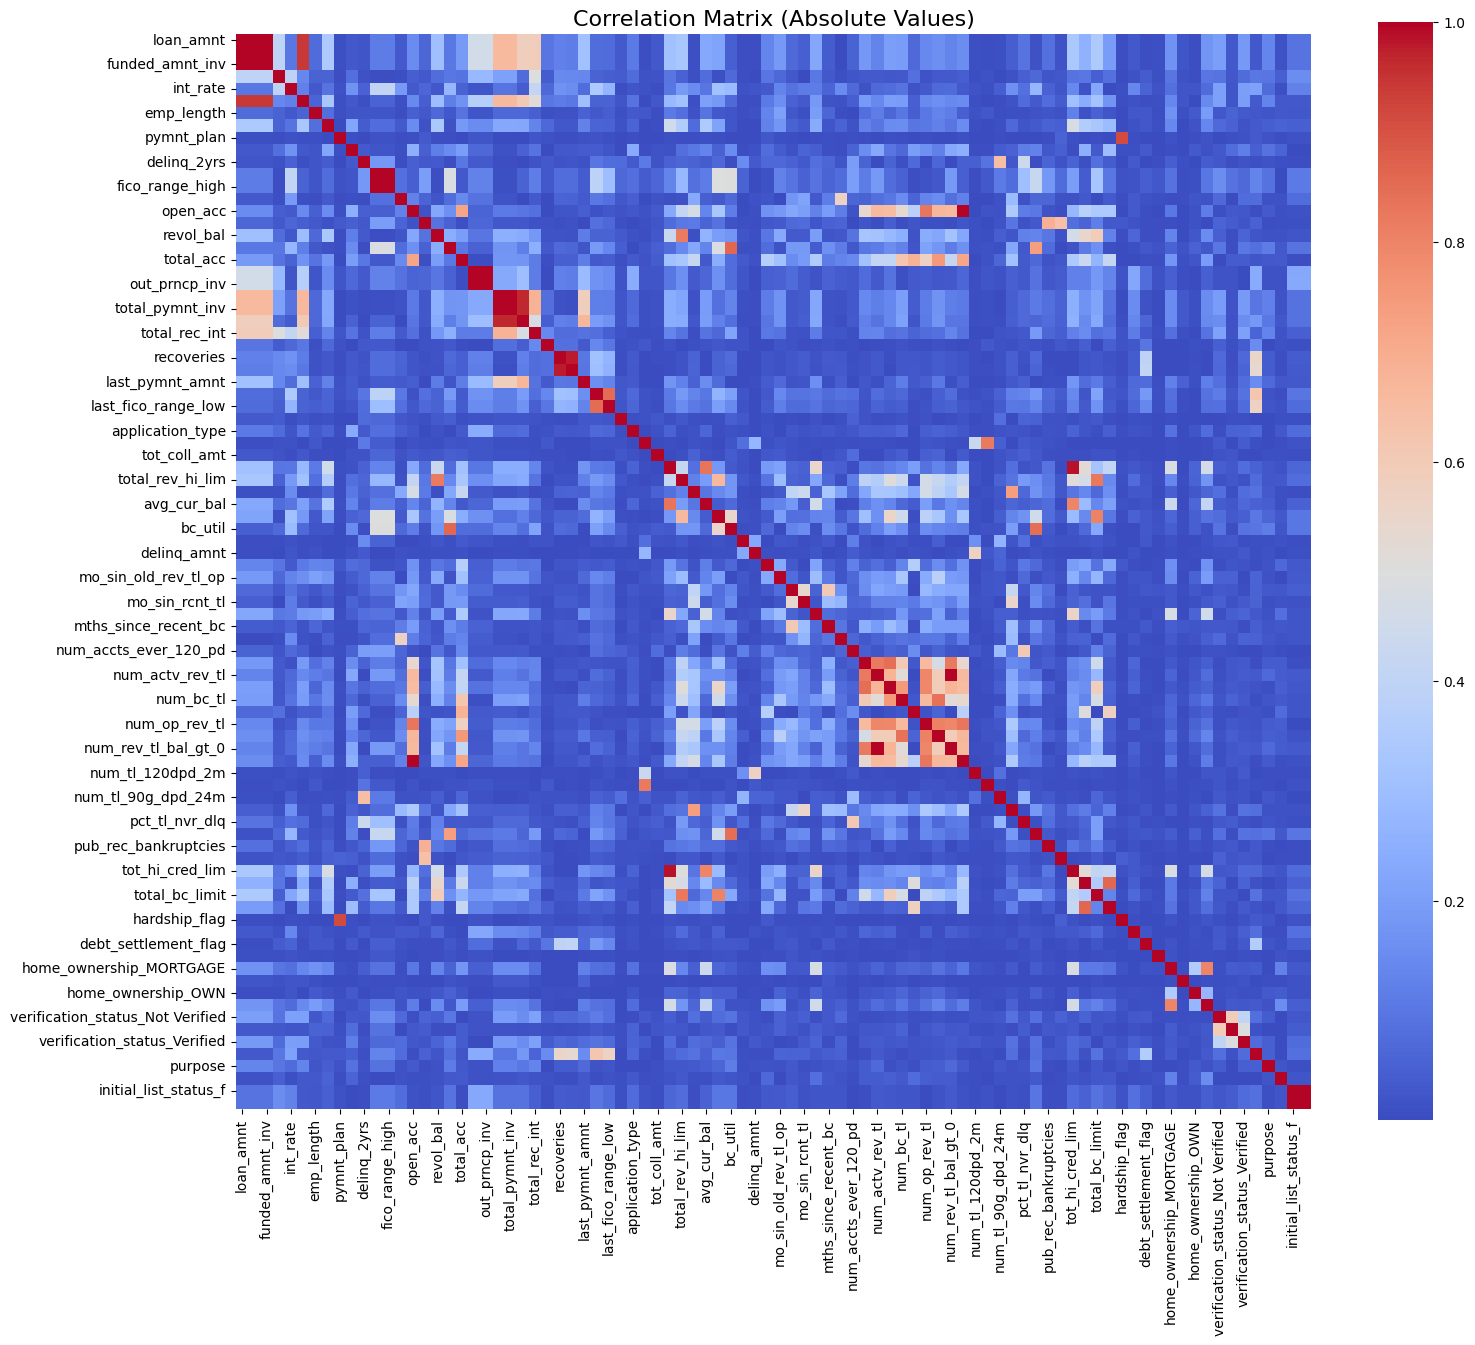

In [25]:
# Print correlational matrix and remove highly correlated columns
x_train_final, dropped_cols = dropHighCorrColumn(x_train_final, 0.8, 16, 16)
x_test_final = x_test_final.drop(columns=dropped_cols, errors='ignore')

### 1.4. Train and Predict

In [26]:
# Predict on data set
y_preds = trainAndPredict(x_train_final_svc, y_train, x_test_final_svc, x_train_final, x_test_final)

### 1.5. Evaluate

In [27]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.443,0.285
1,KNeighborsClassifier,1.000,0.542,0.372
2,LinearSVC,1.000,0.401,0.251


### 1.6. Use different scaling and evaluate

#### 1.6.1. Standard Scaler

In [28]:
scaler = StandardScaler()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final_svc))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final_svc))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled = pd.DataFrame(scaler.transform(x_test_final))

In [29]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [30]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.443,0.285
1,KNeighborsClassifier,1.000,0.525,0.355
2,LinearSVC,1.000,0.429,0.273


#### 1.6.2. Normalizer

In [31]:
scaler = Normalizer()
x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final_svc))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final_svc))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled = pd.DataFrame(scaler.transform(x_test_final))

In [32]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [33]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.448,0.289
1,KNeighborsClassifier,1.000,0.528,0.358
2,LinearSVC,1.000,0.214,0.120


#### 1.6.3. MinMax Scaler

In [34]:
scaler = MinMaxScaler()
x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final_svc))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final_svc))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled = pd.DataFrame(scaler.transform(x_test_final))

In [35]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [36]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.443,0.285
1,KNeighborsClassifier,1.000,0.529,0.359
2,LinearSVC,1.000,0.427,0.271


### 1.7. Hyperparamter tuning

In [37]:
y_preds = trainAndPredictWithTuning(x_train_final_svc, y_train, x_test_final_svc, x_train_final, x_test_final)

In [38]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier n_estimator=25,1.000,0.462,0.300
1,RandomForestClassifier n_estimator=50,1.000,0.457,0.296
2,RandomForestClassifier n_estimator=100,1.000,0.453,0.293
3,RandomForestClassifier n_estimator=150,1.000,0.452,0.292
4,KNeighborsClassifier n_neighbors=2,1.000,0.557,0.386
5,KNeighborsClassifier n_neighbors=5,1.000,0.529,0.360
6,KNeighborsClassifier n_neighbors=7,1.000,0.534,0.365
7,KNeighborsClassifier n_neighbors=10,1.000,0.539,0.369
8,LinearSVC C=0.01,1.000,0.410,0.258
9,LinearSVC C=0.1,1.000,0.435,0.278


## 2. Breast Cancer Dataset

### 2.1. Missing values

In [39]:
# Find missing values per column
missing_values = checkMissingValuesPerColumn(cancer_data_trn)
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)

Series([], dtype: int64)


### 2.2. Drop irrelevant columns

In [40]:
columns_to_drop = ['ID']
cancer_data_trn = cancer_data_trn.drop(columns=columns_to_drop, errors='ignore')
cancer_data_tst = cancer_data_tst.drop(columns=columns_to_drop, errors='ignore')
cancer_data_trn.head()

,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,True,13.96,17.05,91.43,602.4,0.10960,0.12790,0.09789,0.05246,0.1908,...,16.39,22.07,108.10,826.0,0.1512,0.3262,0.3209,0.1374,0.3068,0.07957
1,True,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
2,True,21.37,15.10,141.30,1386.0,0.10010,0.15150,0.19320,0.12550,0.1973,...,22.69,21.84,152.10,1535.0,0.1192,0.2840,0.4024,0.1966,0.2730,0.08666
3,True,18.22,18.87,118.70,1027.0,0.09746,0.11170,0.11300,0.07950,0.1807,...,21.84,25.00,140.90,1485.0,0.1434,0.2763,0.3853,0.1776,0.2812,0.08198
4,False,15.71,13.93,102.00,761.7,0.09462,0.09462,0.07135,0.05933,0.1816,...,17.50,19.25,114.30,922.8,0.1223,0.1949,0.1709,0.1374,0.2723,0.07071


### 2.3. Column transformation

In [41]:
num_cols_initial, cat_cols_initial = filterColumnsWithType(cancer_data_trn)
num_cols = cancer_data_trn.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [42]:
# Convert target column
cancer_data_trn['class'] = cancer_data_trn['class'].astype(int)
cancer_data_tst['class'] = cancer_data_tst['class'].astype(int)

In [43]:
# Split dependent and independent features of both test and train data set
x_train, y_train = splitDependentIndependent(cancer_data_trn, 'class')
x_test, y_test = splitDependentIndependent(cancer_data_tst, 'class')

In [44]:
x_train.head()

,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,fractalDimensionMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
0,13.96,17.05,91.43,602.4,0.10960,0.12790,0.09789,0.05246,0.1908,0.06130,...,16.39,22.07,108.10,826.0,0.1512,0.3262,0.3209,0.1374,0.3068,0.07957
1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
2,21.37,15.10,141.30,1386.0,0.10010,0.15150,0.19320,0.12550,0.1973,0.06183,...,22.69,21.84,152.10,1535.0,0.1192,0.2840,0.4024,0.1966,0.2730,0.08666
3,18.22,18.87,118.70,1027.0,0.09746,0.11170,0.11300,0.07950,0.1807,0.05664,...,21.84,25.00,140.90,1485.0,0.1434,0.2763,0.3853,0.1776,0.2812,0.08198
4,15.71,13.93,102.00,761.7,0.09462,0.09462,0.07135,0.05933,0.1816,0.05723,...,17.50,19.25,114.30,922.8,0.1223,0.1949,0.1709,0.1374,0.2723,0.07071


In [45]:
cat_cols = x_train.select_dtypes(include=['object']).columns.tolist()

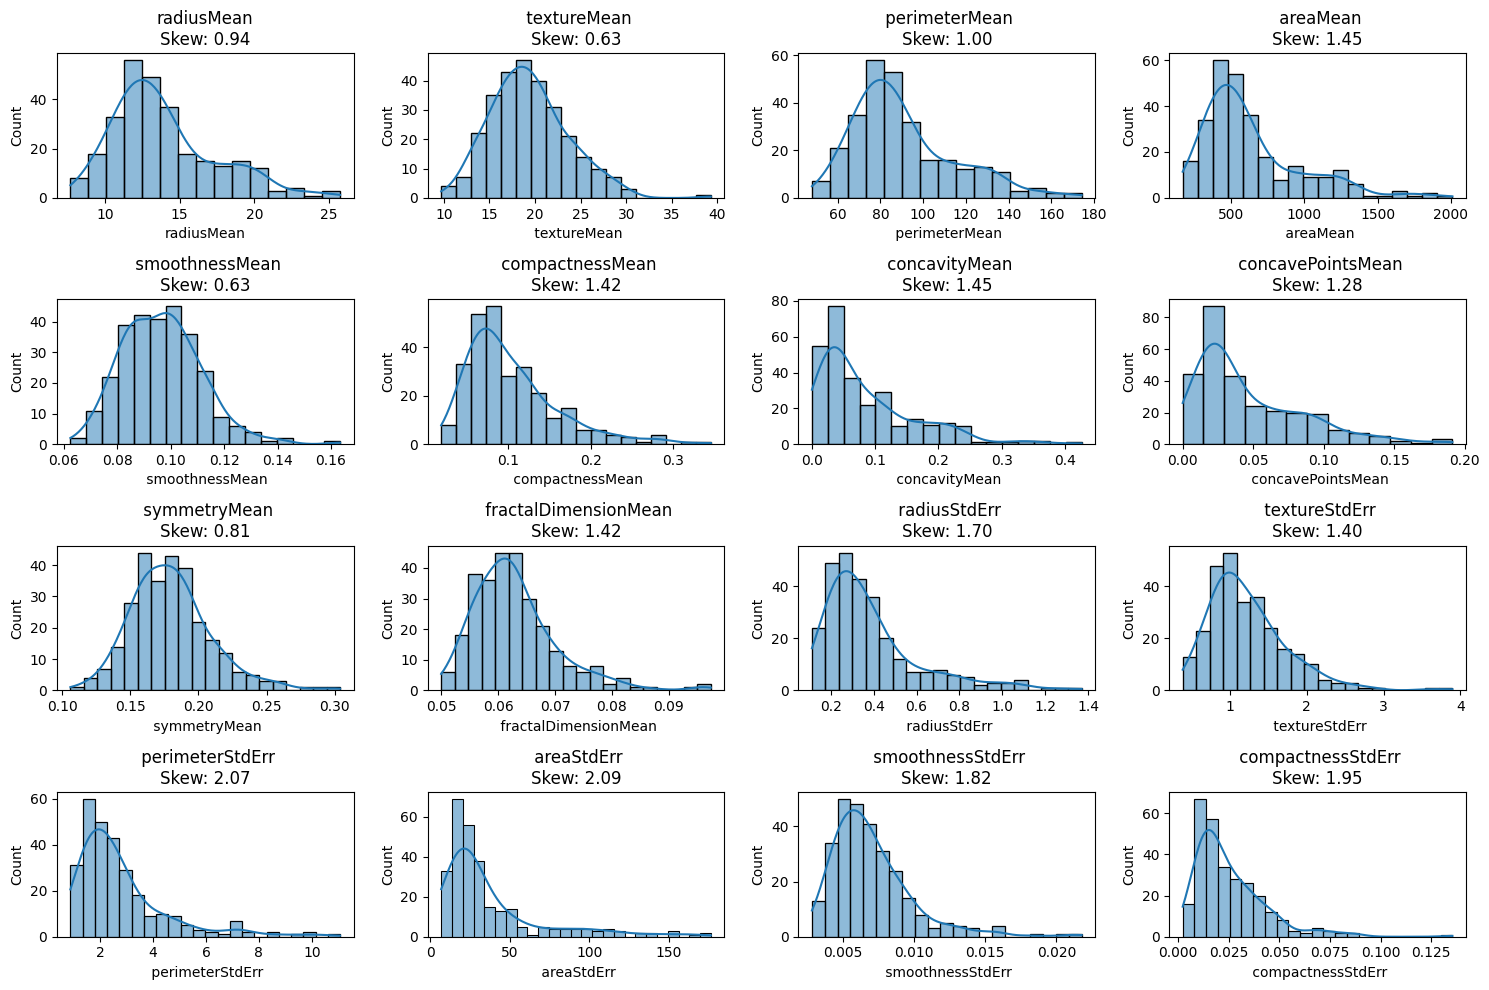

In [46]:
subset = num_cols_initial[0:16]
plotSkewedNess(x_train, subset, 4)

In [47]:
# Handle skewed numerical features
skewed_feats = x_train.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 0.75].index.tolist()

x_train[skewed_cols] = np.log1p(x_train[skewed_cols])
x_test[skewed_cols] = np.log1p(x_test[skewed_cols])

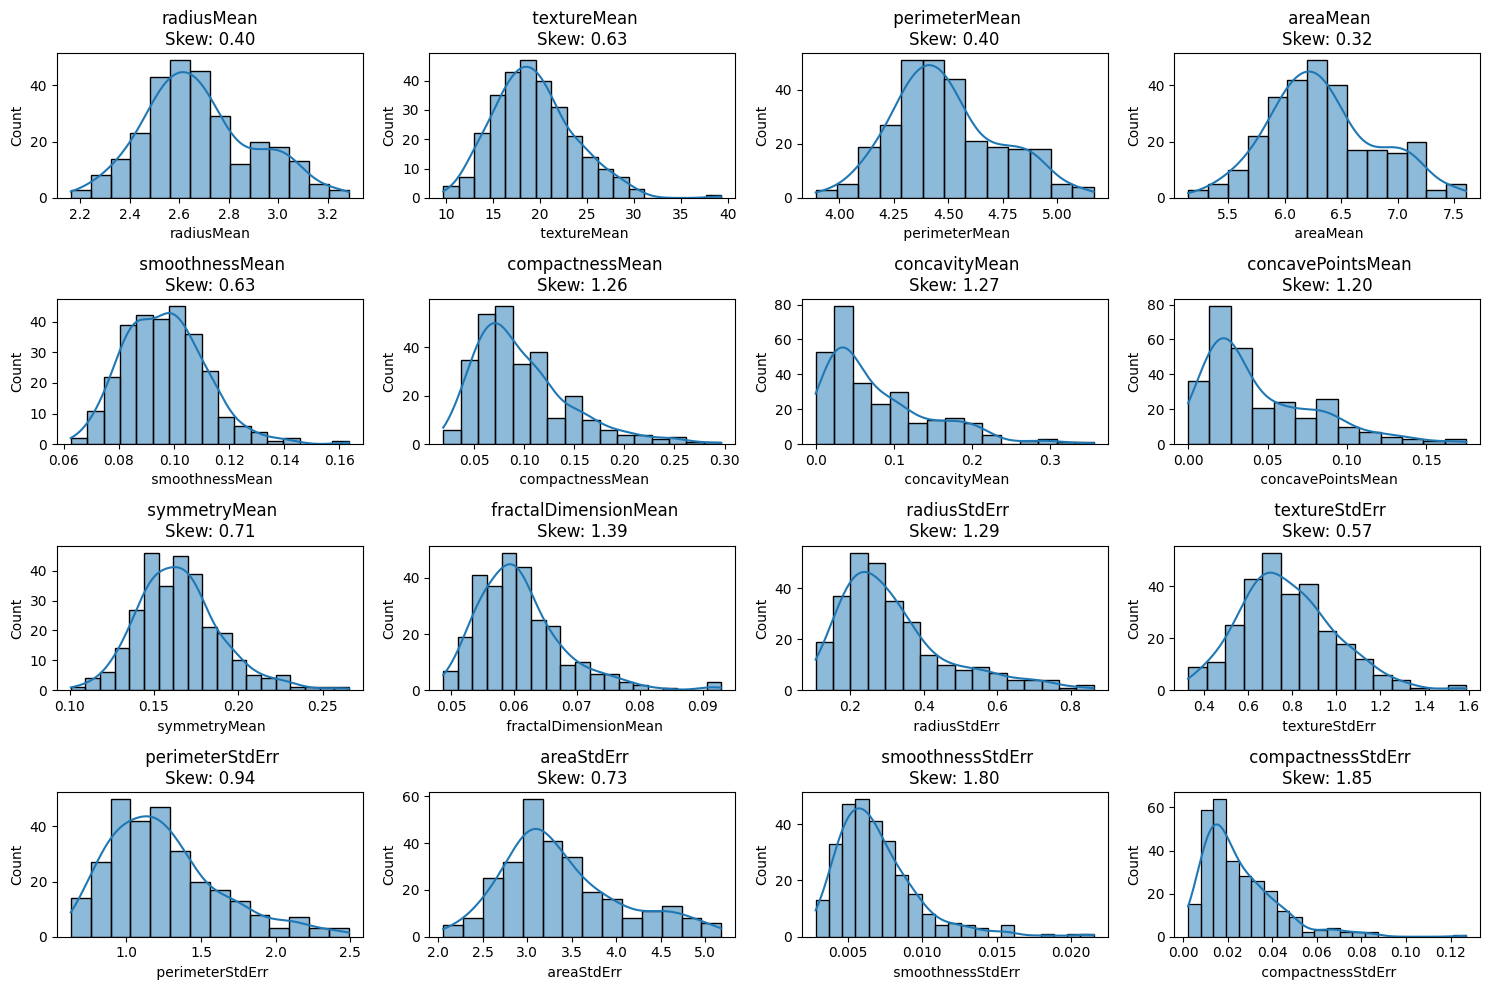

In [48]:
plotSkewedNess(x_train, subset, 4)

In [49]:
findOutliers(x_train)

For:  1.5
['radiusMean', ' textureMean', ' perimeterMean', ' areaMean', ' smoothnessMean', ' compactnessMean', ' concavityMean', ' concavePointsMean', ' symmetryMean', ' fractalDimensionMean', ' radiusStdErr', ' textureStdErr', ' perimeterStdErr', ' areaStdErr', ' smoothnessStdErr', ' compactnessStdErr', ' concavityStdErr', ' concavePointsStdErr', ' symmetryStdErr', ' fractalDimensionStdErr', ' radiusWorst', ' textureWorst', ' perimeterWorst', ' areaWorst', ' smoothnessWorst', ' compactnessWorst', ' concavityWorst', ' symmetryWorst', ' fractalDimensionWorst']
29
For:  1.8
[' textureMean', ' smoothnessMean', ' compactnessMean', ' concavityMean', ' concavePointsMean', ' symmetryMean', ' fractalDimensionMean', ' radiusStdErr', ' textureStdErr', ' perimeterStdErr', ' areaStdErr', ' smoothnessStdErr', ' compactnessStdErr', ' concavityStdErr', ' concavePointsStdErr', ' symmetryStdErr', ' fractalDimensionStdErr', ' smoothnessWorst', ' compactnessWorst', ' concavityWorst', ' symmetryWorst', ' 

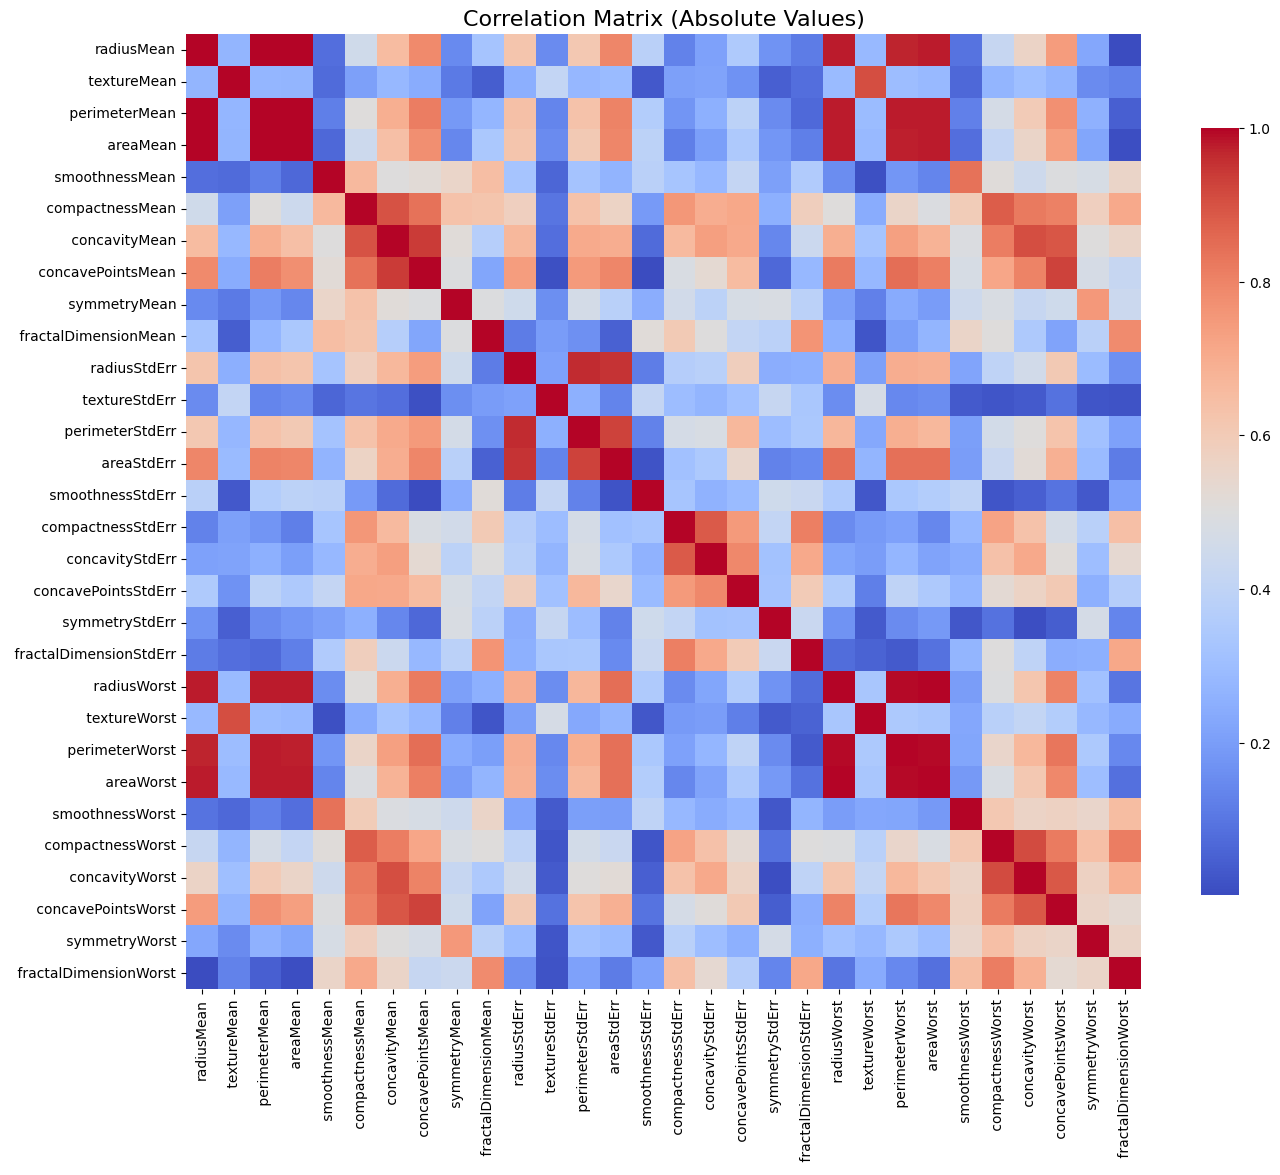

In [50]:
x_train_final, dropped_cols = dropHighCorrColumn(x_train, 0.8, 14, 12)
x_test_final = x_test.drop(columns=dropped_cols, errors='ignore')

### 2.4. Train and Predict

In [51]:
y_preds = trainAndPredict(x_train_final, y_train, x_test_final, x_train, x_test)

### 2.5. Evaluate

In [52]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.784,0.644
1,KNeighborsClassifier,1.000,0.817,0.690
2,LinearSVC,1.000,0.784,0.644


### 2.6. Use different scaling and evaluate

#### 2.6.1. Standard Scaler

In [53]:
scaler = StandardScaler()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_test_scaled = pd.DataFrame(scaler.transform(x_test))

In [54]:
y_preds = trainAndPredict(x_train_final, y_train, x_test_final, x_train, x_test)

In [55]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.784,0.644
1,KNeighborsClassifier,1.000,0.817,0.690
2,LinearSVC,1.000,0.784,0.644


#### 2.6.2. Normalizer

In [56]:
scaler = Normalizer()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_test_scaled = pd.DataFrame(scaler.transform(x_test))

In [57]:
y_preds = trainAndPredict(x_train_final, y_train, x_test_final, x_train, x_test)

In [58]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.784,0.644
1,KNeighborsClassifier,1.000,0.817,0.690
2,LinearSVC,1.000,0.784,0.644


#### 2.6.3. MinMax Scaler

In [59]:
scaler = MinMaxScaler()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_test_scaled = pd.DataFrame(scaler.transform(x_test))

In [60]:
y_preds = trainAndPredict(x_train_final, y_train, x_test_final, x_train, x_test)

In [61]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,0.784,0.644
1,KNeighborsClassifier,1.000,0.817,0.690
2,LinearSVC,1.000,0.784,0.644


### 2.7. Hyperparameter Tuning

In [62]:
y_preds = trainAndPredictWithTuning(x_train_final, y_train, x_test_final, x_train, x_test)

In [63]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier n_estimator=25,1.000,0.786,0.648
1,RandomForestClassifier n_estimator=50,1.000,0.786,0.648
2,RandomForestClassifier n_estimator=100,1.000,0.778,0.637
3,RandomForestClassifier n_estimator=150,1.000,0.773,0.630
4,KNeighborsClassifier n_neighbors=2,1.000,0.864,0.761
5,KNeighborsClassifier n_neighbors=5,1.000,0.843,0.729
6,KNeighborsClassifier n_neighbors=7,1.000,0.848,0.736
7,KNeighborsClassifier n_neighbors=10,1.000,0.862,0.757
8,LinearSVC C=0.01,1.000,0.995,0.989
9,LinearSVC C=0.1,1.000,0.853,0.743


## 3. Loan Default Dataset

### 3.1. Missing values

In [64]:
missing_values = checkMissingValuesPerColumn(default_data)
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)

Series([], dtype: int64)


### 3.2. Drop irrelevant columns

In [65]:
columns_to_drop = ['LoanID']
default_data = default_data.drop(columns=columns_to_drop, errors='ignore')
default_data.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


### 3.3. Column transformation

In [66]:
num_cols_initial, cat_cols_initial = filterColumnsWithType(default_data)

In [67]:
# Convert binary categorical columns to 0/1
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
for col in binary_cols:
    if col in default_data.columns:
        default_data[col] = default_data[col].map({'Yes': 1, 'No': 0})
default_data.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,1,1,Other,1,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,0,0,Other,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,1,1,Auto,0,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,0,0,Business,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,0,1,Auto,0,0


In [68]:
# Encode remaining categorical columns
label_encoder = LabelEncoder()
label_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose']
for col in label_cols:
    default_data[col] = label_encoder.fit_transform(default_data[col])
default_data.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,0,0,0,1,1,4,1,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2,0,1,0,0,4,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,2,3,0,1,1,0,0,1
3,32,31713,44799,743,0,3,7.07,24,0.23,1,0,1,0,0,1,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,3,0,0,1,0,0,0


In [69]:
# Split data in train and test set
default_data_trn, default_data_tst = train_test_split(default_data, test_size=0.2, random_state=1234)

#Split X & y features
x_train = default_data_trn.drop('Default', axis=1)
y_train = default_data_trn['Default']

x_test = default_data_tst.drop('Default', axis=1)
y_test = default_data_tst['Default']

# Segregate number and categorical columns
num_cols, cat_cols = filterColumnsWithType(x_train)

# Split numeric and categorical columns
x_trn_num = x_train[num_cols].copy()
x_tst_num = x_test[num_cols].copy()

x_trn_cat = x_train[cat_cols].copy()
x_tst_cat = x_test[cat_cols].copy()

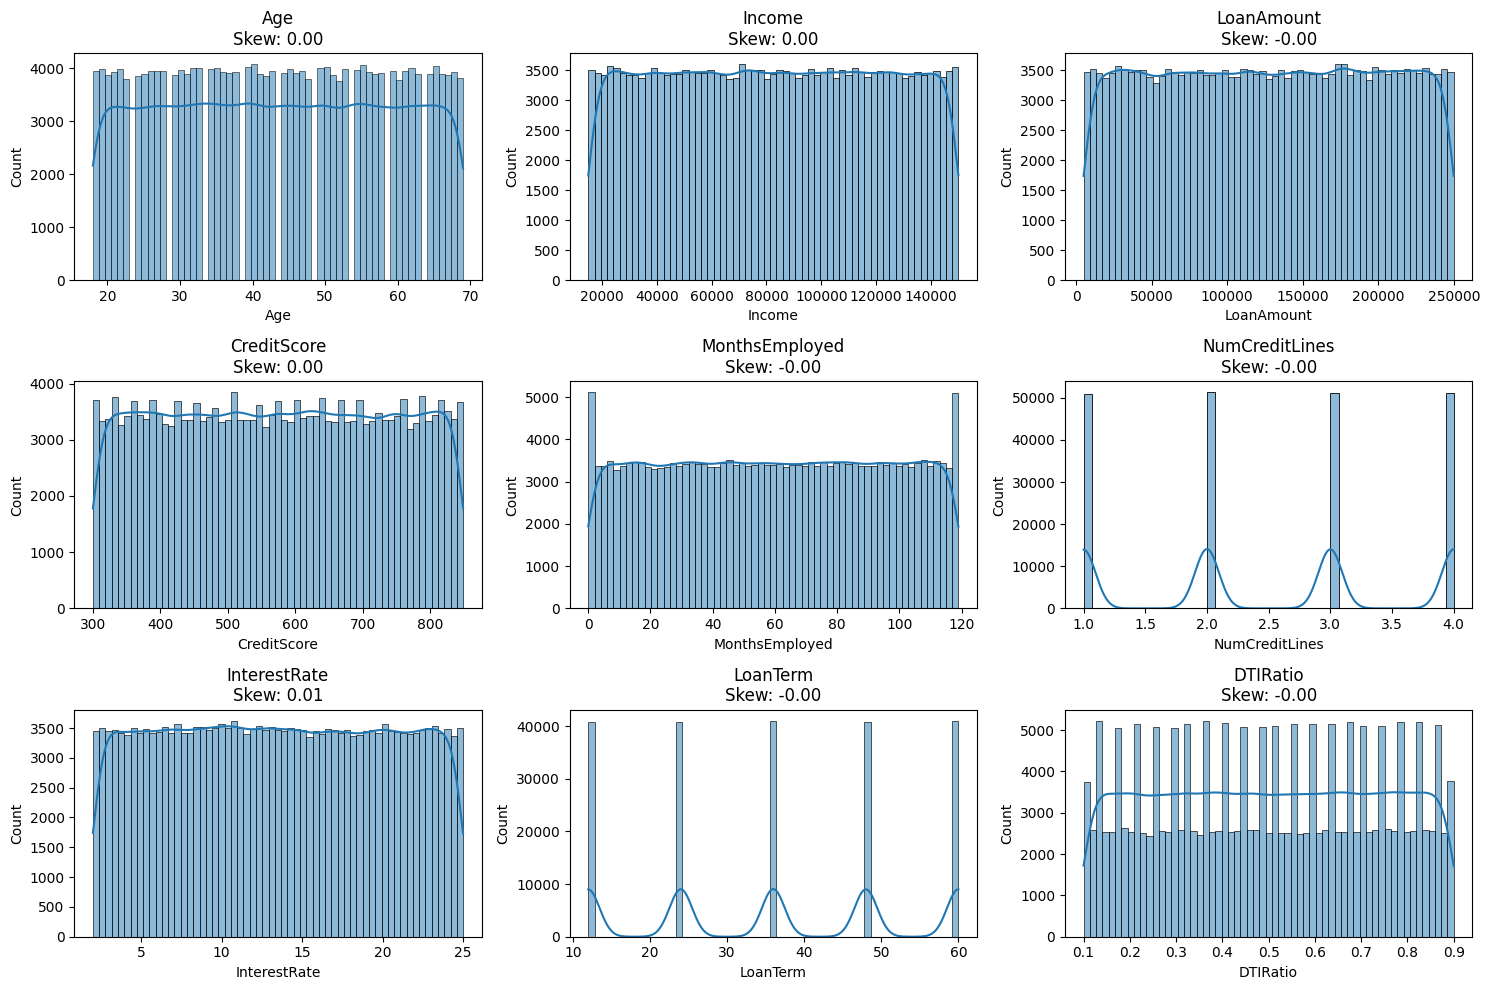

In [70]:
subset = num_cols_initial[0:9]
plotSkewedNess(x_trn_num, subset, 3)

In [71]:
# Handle skewed numerical features
skewed_feats = x_trn_num.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 0.75].index.tolist()

x_trn_num[skewed_cols] = np.log1p(x_trn_num[skewed_cols])
x_tst_num[skewed_cols] = np.log1p(x_tst_num[skewed_cols])

In [72]:
# Normalize numerical columns
scaler = StandardScaler()
x_trn_num_scaled = pd.DataFrame(scaler.fit_transform(x_trn_num), columns=num_cols)
x_tst_num_scaled = pd.DataFrame(scaler.fit_transform(x_tst_num), columns=num_cols)
x_trn_num_scaled.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,-0.165369,1.720607,-0.187783,-0.273538,1.571651,-1.344289,-0.151498,0.706535,0.431411,-1.336997,-1.341290,0.001152,1.000935,-1.001073,-1.414953,1.000867
1,1.235769,-1.522252,-1.050167,-0.663560,1.340675,1.341778,-1.575682,-0.708648,0.561278,1.345168,0.448087,1.226548,1.000935,-1.001073,-0.707447,1.000867
2,-1.366344,1.127492,-0.793668,-0.757920,-0.478253,1.341778,-0.859822,0.706535,0.561278,-1.336997,-0.446602,-1.224245,-0.999065,-1.001073,1.415071,1.000867
3,0.234956,1.116234,0.177322,0.814749,0.965341,0.446422,1.619313,-1.416239,-1.430018,0.451113,-0.446602,-1.224245,-0.999065,0.998929,-0.707447,1.000867
4,-1.366344,1.457197,-1.629939,0.217135,-0.651484,0.446422,-1.314959,-0.001056,0.214966,1.345168,1.342775,0.001152,-0.999065,-1.001073,1.415071,1.000867


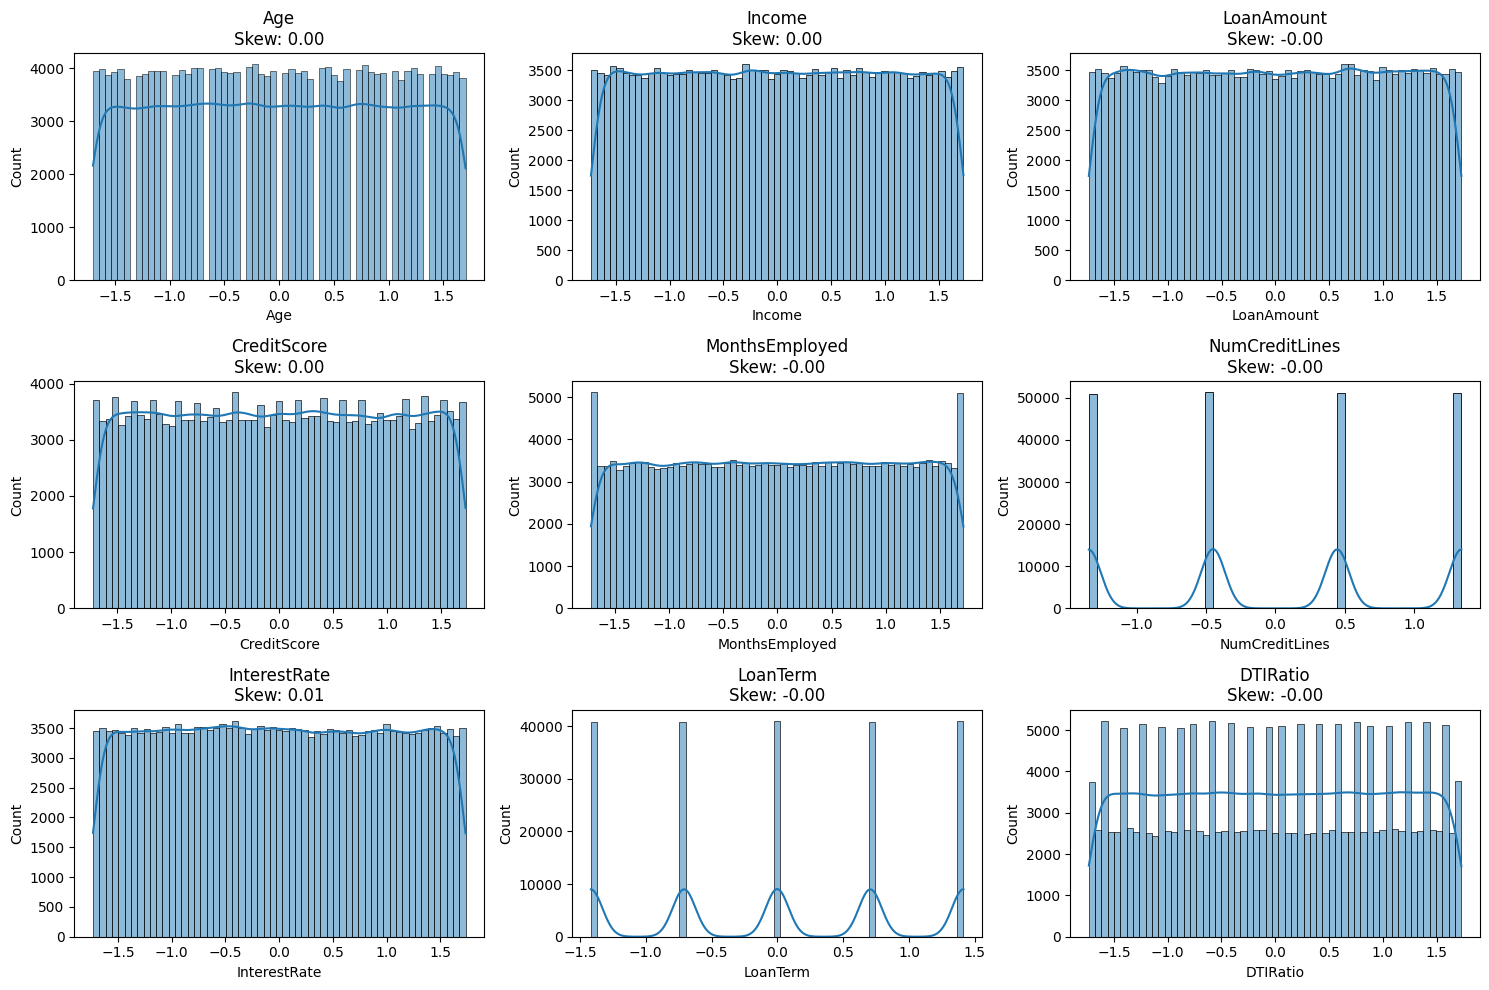

In [73]:
plotSkewedNess(x_trn_num_scaled, subset, 3)

In [74]:
# Merge normalized numerical and categorical columns
x_trn_svm = pd.concat([x_trn_num_scaled.reset_index(drop=True), x_trn_cat.reset_index(drop=True)], axis=1)
x_tst_svm = pd.concat([x_tst_num_scaled.reset_index(drop=True), x_tst_cat.reset_index(drop=True)], axis=1)

In [75]:
findOutliers(x_trn_num)

For:  1.5
[]
0
For:  1.8
[]
0
For:  2
[]
0
For:  3
[]
0
For:  4
[]
0


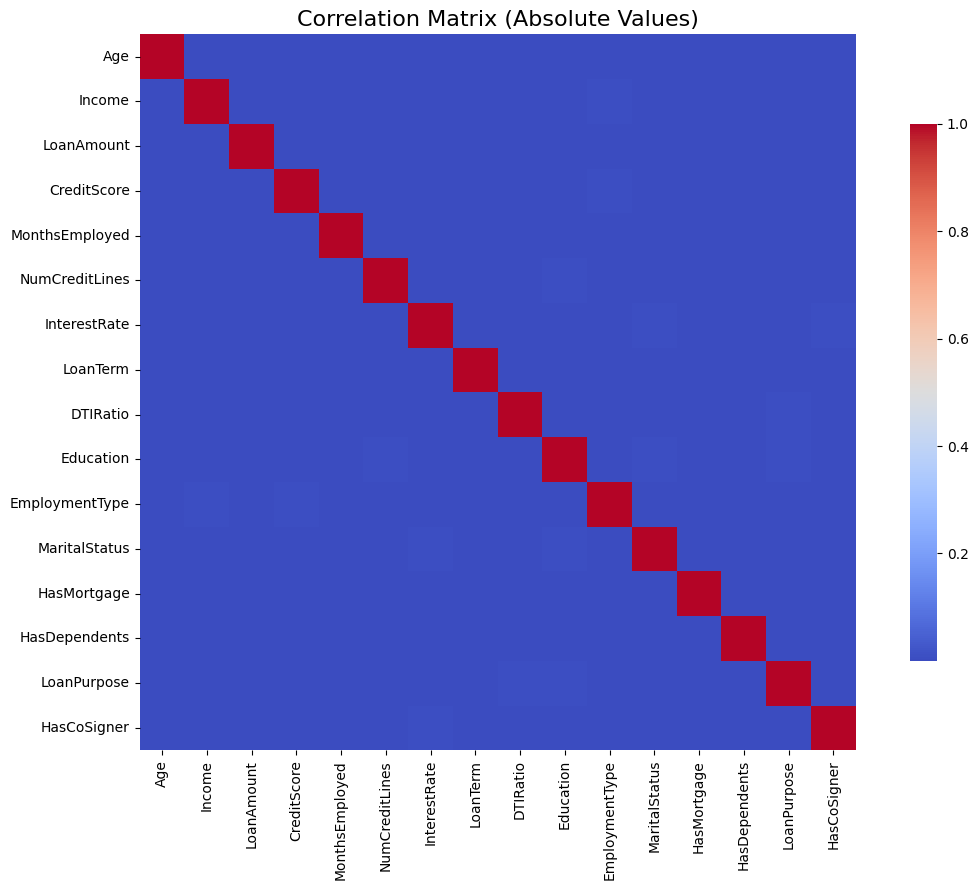

In [76]:
x_train_final, dropped_cols = dropHighCorrColumn(x_trn_svm, 0.8, 12, 9)
x_test_final = x_tst_svm.drop(columns=dropped_cols, errors='ignore')

##### So we have two types of data sets. 
##### 1. default_data_trn where only categorical columns are transformed
##### 2. default_data_trn_svm, where categorical columns are transformned and the numerical columns are normalized

### 3.4. Train and Predict

In [77]:
y_preds = trainAndPredict(x_train_final, y_train, x_test_final, x_train, x_test)

### 3.5. Evaluate

In [78]:
printScores(y_preds)

C:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,0.854,0.838,0.885
1,KNeighborsClassifier,0.814,0.832,0.873
2,LinearSVC,0.779,0.828,0.883


### 3.6. Use different scaling and evaluate

#### 3.6.1. Standard Scaler

In [79]:
scaler = StandardScaler()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_test_scaled = pd.DataFrame(scaler.transform(x_test))

In [80]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [81]:
printScores(y_preds)

C:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,0.855,0.838,0.885
1,KNeighborsClassifier,0.823,0.837,0.874
2,LinearSVC,0.779,0.828,0.883


#### 3.6.2. Normalizer

In [82]:
scaler = Normalizer()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_test_scaled = pd.DataFrame(scaler.transform(x_test))

In [83]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [84]:
printScores(y_preds)

C:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,0.853,0.839,0.885
1,KNeighborsClassifier,0.815,0.833,0.873
2,LinearSVC,0.779,0.828,0.883


#### 3.6.3. MinMax Scaler

In [85]:
scaler = MinMaxScaler()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_final))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_final))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train))
x_test_scaled = pd.DataFrame(scaler.transform(x_test))

In [86]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [87]:
printScores(y_preds)

C:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,0.854,0.838,0.885
1,KNeighborsClassifier,0.818,0.834,0.873
2,LinearSVC,0.779,0.828,0.883


### 3.7. Hyperparameter tuning

In [88]:
y_preds = trainAndPredictWithTuning(x_train_final, y_train, x_test_final, x_train, x_test)

In [89]:
printScores(y_preds)

C:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Sam\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier n_estimator=25,0.844,0.841,0.883
1,RandomForestClassifier n_estimator=50,0.852,0.839,0.885
2,RandomForestClassifier n_estimator=100,0.855,0.839,0.885
3,RandomForestClassifier n_estimator=150,0.855,0.839,0.885
4,KNeighborsClassifier n_neighbors=2,0.815,0.832,0.874
5,KNeighborsClassifier n_neighbors=5,0.823,0.837,0.874
6,KNeighborsClassifier n_neighbors=7,0.827,0.836,0.879
7,KNeighborsClassifier n_neighbors=10,0.829,0.831,0.882
8,LinearSVC C=0.01,0.779,0.828,0.883
9,LinearSVC C=0.1,0.779,0.828,0.883


## 4. Mushroom Dataset

### 4.1. Missing values

In [90]:
missing_values = checkMissingValuesPerColumn(mushroom_data)
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)

Series([], dtype: int64)


### 4.2. Drop irrelevant columns

In [91]:
columns_to_drop = ['veil-type']
mushroom_data = mushroom_data.drop(columns=columns_to_drop, errors='ignore')
mushroom_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


### 4.3. Column transformation

In [92]:
# Segregate number and categorical columns
num_cols, cat_cols = filterColumnsWithType(mushroom_data)

In [93]:
# Convert binary categorical columns to 0/1
binary_cols = ['class', 'bruises', 'gill-attachment', 'gill-spacing', 'gill-size']
for col in binary_cols:
    if col in mushroom_data.columns:
        mushroom_data[col] = mushroom_data[col].map({'e': 1, 'p': 0, 't': 1, 'f': 0, 'a': 1, 'c': 1, 'w': 0, 'b': 1, 'n': 0})
mushroom_data['stalk-shape'] = mushroom_data['stalk-shape'].map({'e': 1, 't': 0})
mushroom_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,x,s,n,1,p,0,1,0,k,...,s,s,w,w,w,o,p,k,s,u
1,1,x,s,y,1,a,0,1,1,k,...,s,s,w,w,w,o,p,n,n,g
2,1,b,s,w,1,l,0,1,1,n,...,s,s,w,w,w,o,p,n,n,m
3,0,x,y,w,1,p,0,1,0,n,...,s,s,w,w,w,o,p,k,s,u
4,1,x,s,g,0,n,0,0,1,k,...,s,s,w,w,w,o,e,n,a,g


In [94]:
df = mushroom_data.copy()
df = df.drop(columns=['class'])
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [95]:
mushroom_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,x,s,n,1,p,0,1,0,k,...,s,s,w,w,w,o,p,k,s,u
1,1,x,s,y,1,a,0,1,1,k,...,s,s,w,w,w,o,p,n,n,g
2,1,b,s,w,1,l,0,1,1,n,...,s,s,w,w,w,o,p,n,n,m
3,0,x,y,w,1,p,0,1,0,n,...,s,s,w,w,w,o,p,k,s,u
4,1,x,s,g,0,n,0,0,1,k,...,s,s,w,w,w,o,e,n,a,g


In [96]:
# Split data in train and test set
mushroom_data_trn, mushroom_data_tst = train_test_split(mushroom_data, test_size=0.2, random_state=1234)

#Split X & y features
x_train = mushroom_data_trn.drop('class', axis=1)
y_train = mushroom_data_trn['class']

x_test = mushroom_data_tst.drop('class', axis=1)
y_test = mushroom_data_tst['class']

In [97]:
# Transform categorical columns
x_trn, x_tst = categoricalColumnEncoding(x_train, x_test, y_train)

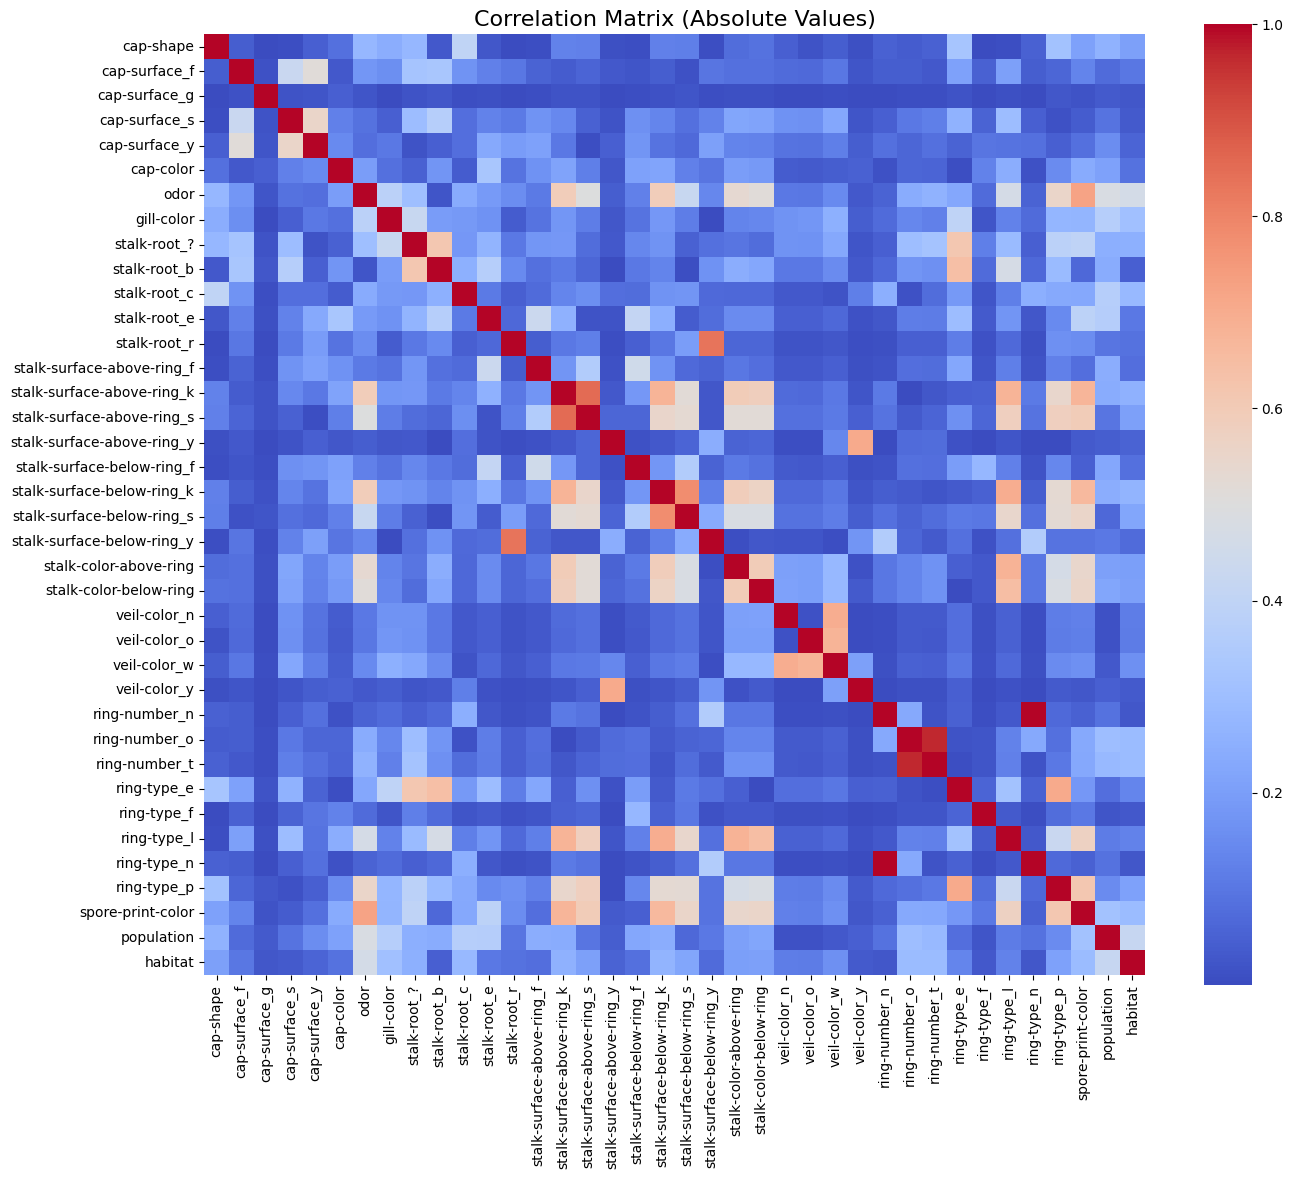

In [98]:
x_train_svm, dropped_cols = dropHighCorrColumn(x_trn, 0.8, 14, 14)
x_test_svm = x_tst.drop(columns=dropped_cols, errors='ignore')

### 4.4. Train and Predict

In [99]:
y_preds = trainAndPredict(x_train_svm, y_train, x_test_svm, x_trn, x_tst)

### 4.5. Evaluate

In [100]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,1.000,1.000
1,KNeighborsClassifier,0.999,0.999,0.999
2,LinearSVC,1.000,1.000,1.000


### 4.6. Use different scaling and evaluate

#### 4.6.1. Standard Scaler

In [101]:
scaler = StandardScaler()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_svm))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_svm))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_trn))
x_test_scaled = pd.DataFrame(scaler.transform(x_tst))

In [102]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [103]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,1.000,1.000
1,KNeighborsClassifier,0.999,0.999,0.999
2,LinearSVC,1.000,1.000,1.000


#### 4.6.2. Normalizer

In [104]:
scaler = Normalizer()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_svm))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_svm))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_trn))
x_test_scaled = pd.DataFrame(scaler.transform(x_tst))

In [105]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [106]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,1.000,1.000
1,KNeighborsClassifier,0.999,0.999,0.999
2,LinearSVC,0.998,0.998,0.998


#### 4.6.3. MinMax Scaler

In [107]:
scaler = MinMaxScaler()

x_train_scaled_svc = pd.DataFrame(scaler.fit_transform(x_train_svm))
x_test_scaled_svc = pd.DataFrame(scaler.transform(x_test_svm))

x_train_scaled = pd.DataFrame(scaler.fit_transform(x_trn))
x_test_scaled = pd.DataFrame(scaler.transform(x_tst))

In [108]:
y_preds = trainAndPredict(x_train_scaled_svc, y_train, x_test_scaled_svc, x_train_scaled, x_test_scaled)

In [109]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier,1.000,1.000,1.000
1,KNeighborsClassifier,0.999,0.999,0.999
2,LinearSVC,1.000,1.000,1.000


### 4.7. Hyperparameter Tuning

In [110]:
y_preds = trainAndPredictWithTuning(x_train_svm, y_train, x_test_svm, x_trn, x_tst)

In [111]:
printScores(y_preds)

,Model,precision_score,f1_score,accuracy_score
0,RandomForestClassifier n_estimator=25,1.000,1.000,1.000
1,RandomForestClassifier n_estimator=50,1.000,1.000,1.000
2,RandomForestClassifier n_estimator=100,1.000,1.000,1.000
3,RandomForestClassifier n_estimator=150,1.000,1.000,1.000
4,KNeighborsClassifier n_neighbors=2,1.000,1.000,1.000
5,KNeighborsClassifier n_neighbors=5,0.999,0.999,0.999
6,KNeighborsClassifier n_neighbors=7,0.999,0.999,0.999
7,KNeighborsClassifier n_neighbors=10,0.999,0.999,0.999
8,LinearSVC C=0.01,0.982,0.981,0.981
9,LinearSVC C=0.1,0.998,0.998,0.998
